In [1]:
import matplotlib as mpl 
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas
import matplotlib.pyplot as plt 
import math

In [2]:
# EC2 Constants - price and requests per second

# EC2 Costs (on demand in us-east-1)
m3m = 0.067
m5l = 0.096
m5xl = 0.192
m52xl = 0.384

elb = 0.0225
elb_lcu = 0.008

# Calculated requests per second in varying EC2 instance types, with an application load balancer
m3m_rps = 27.0
m5l_rps = 63.0
m5xl_rps = 114.0
m52xl_rps = 196.0


In [3]:
# Input parameters

# Min/max requests per second
min_rps = 1
max_rps = 275

# Time to process in seconds
process_time = 0.5

# Memory in MB
memory = 128.0

In [4]:
def cost_model(process_time=process_time, memory=memory, min_rps=min_rps, max_rps=max_rps):
    rps = np.linspace(min_rps, max_rps, 100)
    df = pandas.DataFrame({'rps': rps})

    # Lambda cost model
    df['rpm'] = df['rps'] * 60 * 60 * 24 * 30
    df['compute_time'] = df['rpm'] * process_time
    df['gb_per_second'] = df['compute_time'] * memory / 1024.0
    df['gb_per_second'] = df['gb_per_second']  - 400000 # subtract off free
    df['gb_per_second'] = df['gb_per_second'].apply(lambda x: 0 if x < 0 else x)
    df['compute_cost'] = df['gb_per_second'] * 0.00001667
    df['request_millions'] = df['rpm'] - 1000000 # subtract off free
    df['request_millions'] = df['request_millions'] / 1000000
    df['request_cost'] = df['request_millions'] * 0.2
    df['total_cost'] = df['compute_cost'] + df['request_cost']

    # EC2 cost model
    # Assume that requests per second is the highest LCU rule
    df['lcu_total'] = df['rps'] / 25 * elb_lcu

    df['m3m_monthly'] = m3m * 24 * 30 + elb * 24 * 30 + df['lcu_total']
    df['m5l_monthly'] = m5l * 24 * 30 + elb * 24 * 30 + df['lcu_total']
    df['m5xl_monthly'] = m5xl * 24 * 30 + elb * 24 * 30 + df['lcu_total']
    df['m52xl_monthly'] = m52xl * 24 * 30 + elb * 24 * 30 + df['lcu_total']

    # For high availabilty
    min_instances = 3

    df['m3m_required'] = df['rps'].apply(lambda x: max(int(math.ceil(float(x) / m3m_rps)), min_instances))
    df['m5l_required'] = df['rps'].apply(lambda x: max(int(math.ceil(float(x) / m5l_rps)), min_instances))
    df['m5xl_required'] = df['rps'].apply(lambda x: max(int(math.ceil(float(x) / m5xl_rps)), min_instances))
    df['m52xl_required'] = df['rps'].apply(lambda x: max(int(math.ceil(float(x) / m52xl_rps)), min_instances))

    df['m3m_cost'] = df['m3m_required'] * df['m3m_monthly']
    df['m5l_cost'] = df['m5l_required'] * df['m5l_monthly']
    df['m5xl_cost'] = df['m5xl_required'] * df['m5xl_monthly']
    df['m52xl_cost'] = df['m52xl_required'] * df['m52xl_monthly']
    
    return df

def plot(process_time=process_time, memory=memory, min_rps=min_rps, max_rps=max_rps, title='ec2 vs. lambda'):
    df = cost_model(process_time=process_time, memory=memory, min_rps=min_rps, max_rps=max_rps)

    plt.figure()
    plt.title(title)
    plt.ylabel('cost')
    plt.xlabel('rps')
    plt.plot(df['rps'], df['total_cost'], label="lambda")
    plt.plot(df['rps'], df['m3m_cost'], label="m3.medium")
    plt.plot(df['rps'], df['m5l_cost'], label="m5.large")
    plt.plot(df['rps'], df['m5xl_cost'], label="m5.xlarge")
    plt.plot(df['rps'], df['m52xl_cost'], label="m5.2xlarge")
    plt.legend()
    plt.show()

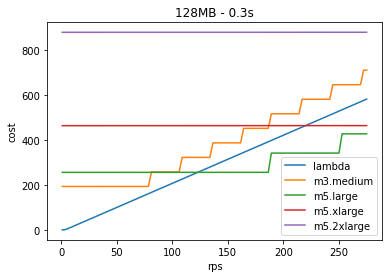

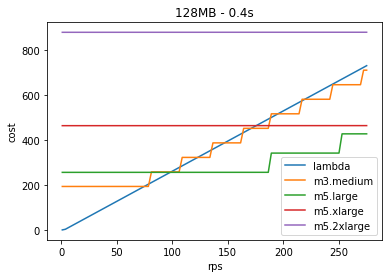

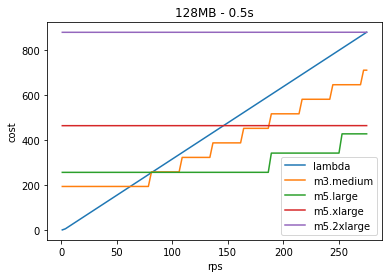

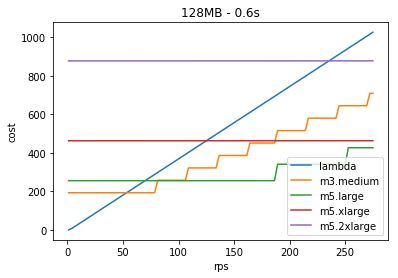

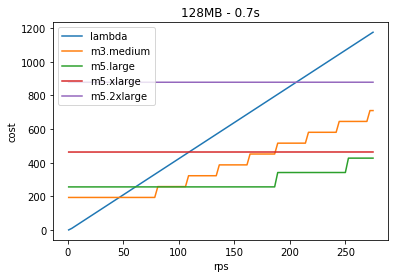

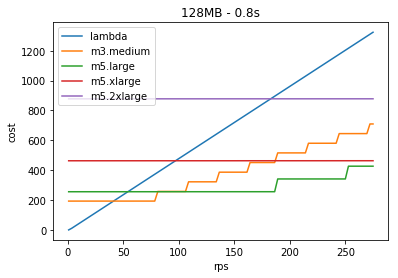

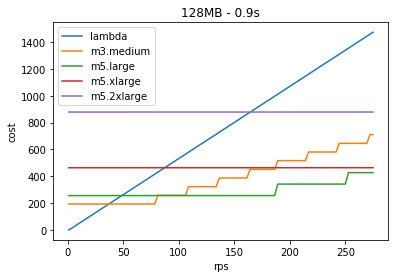

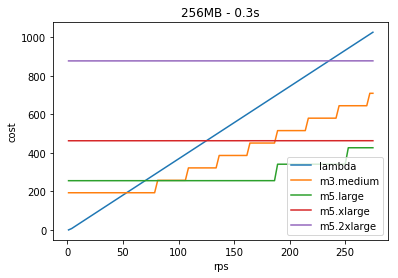

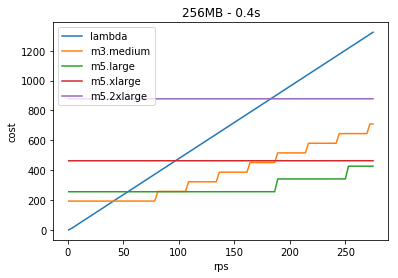

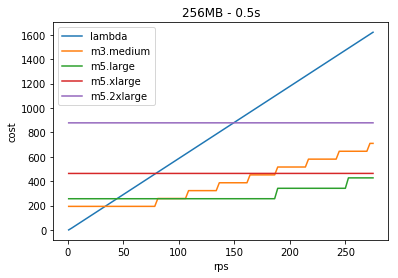

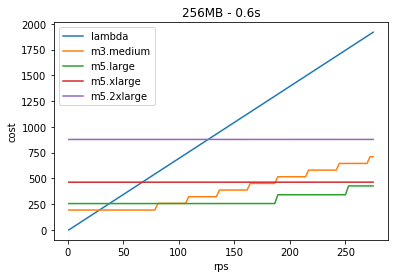

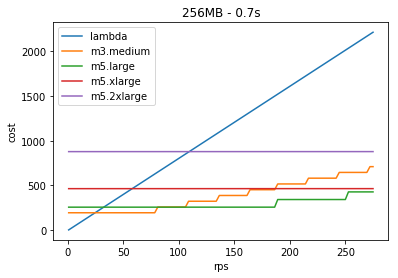

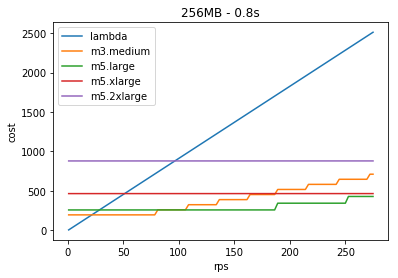

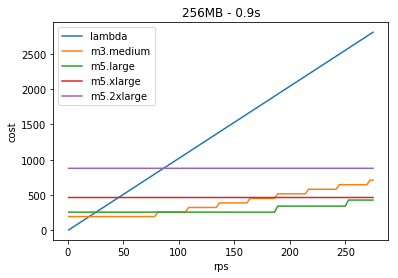

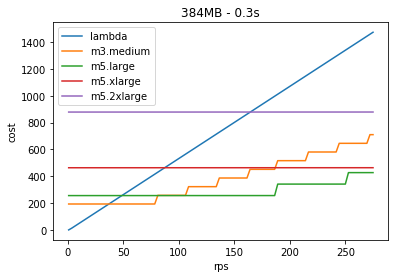

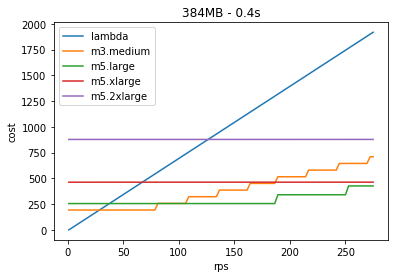

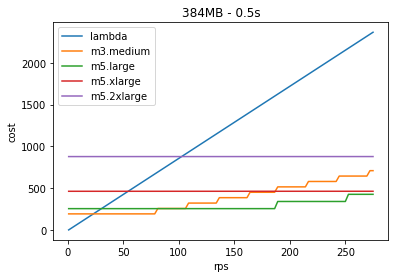

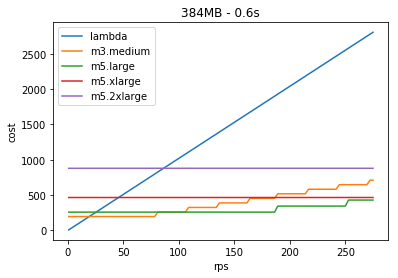

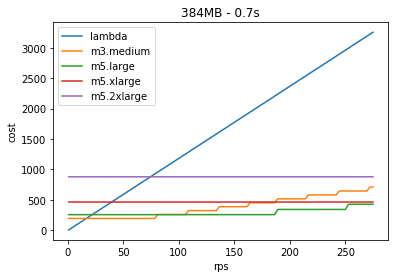

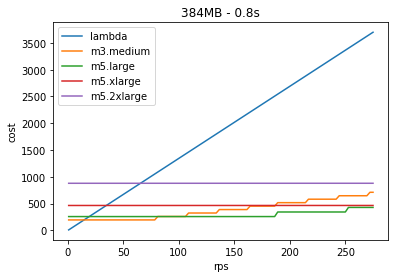

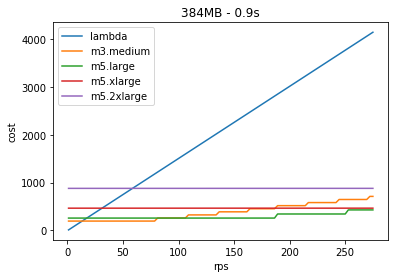

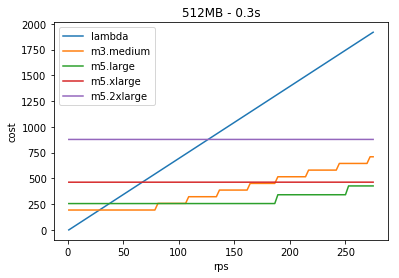

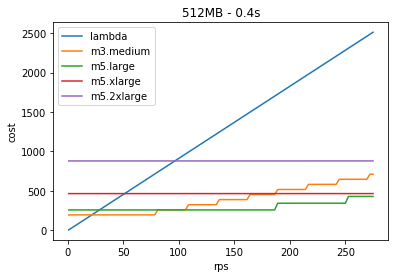

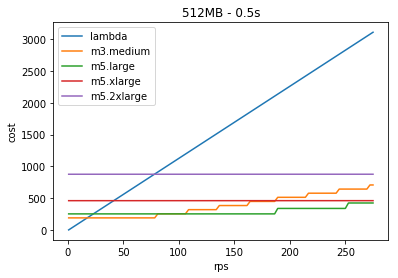

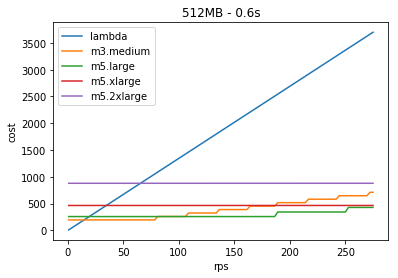

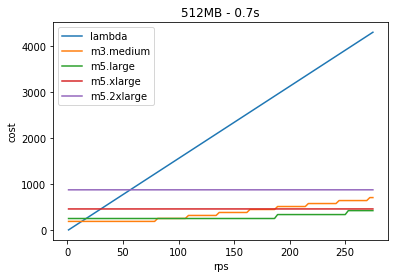

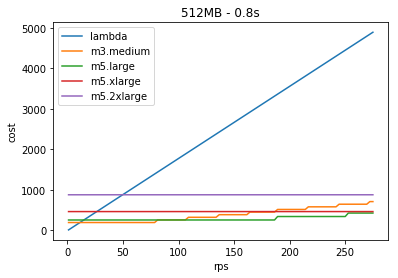

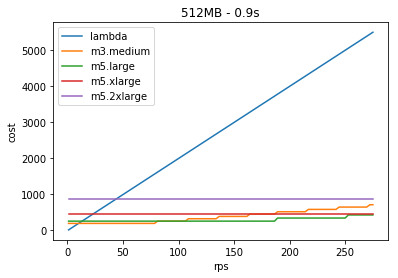

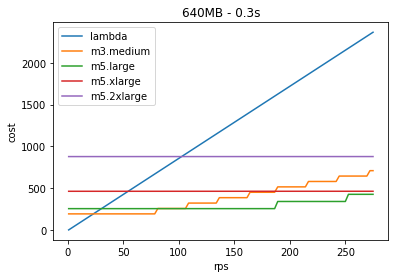

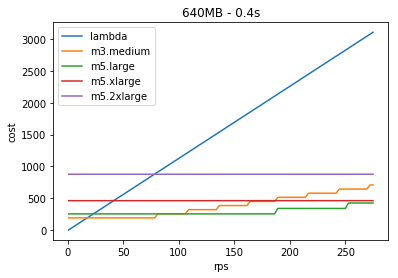

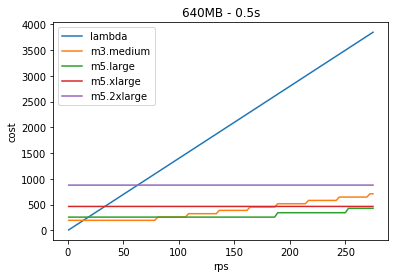

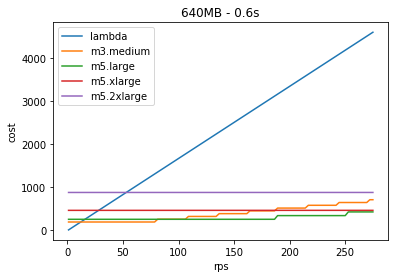

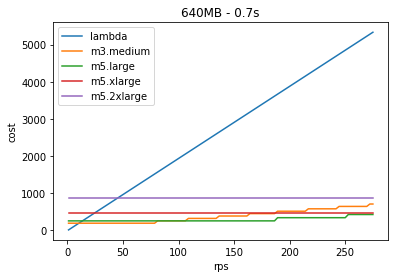

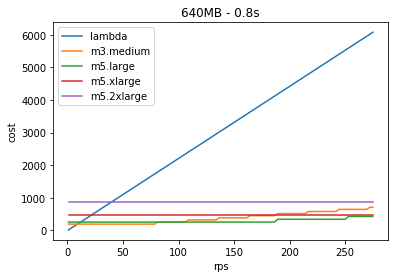

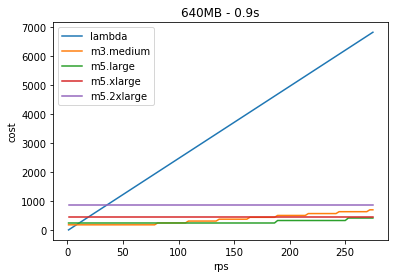

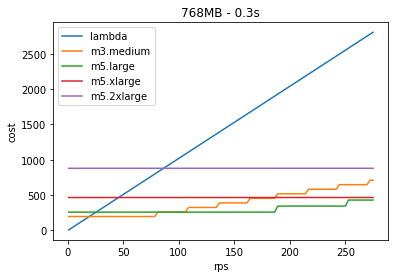

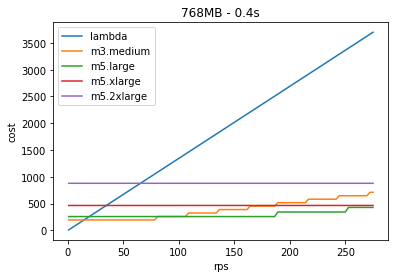

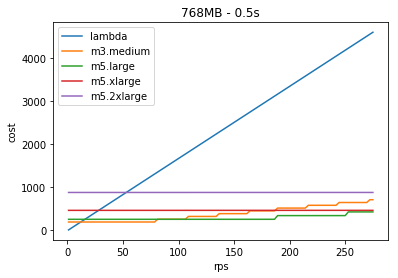

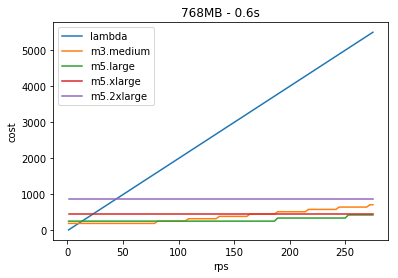

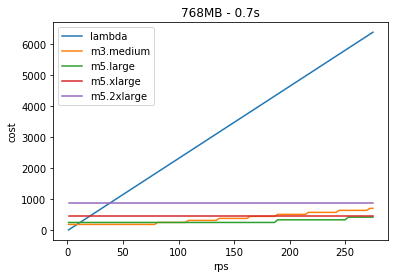

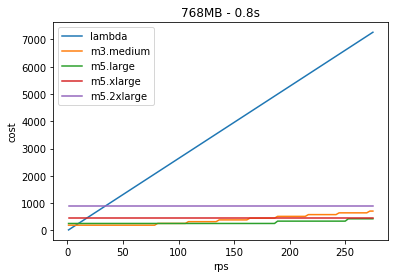

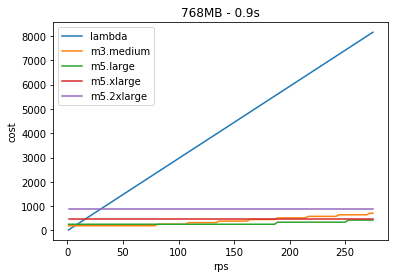

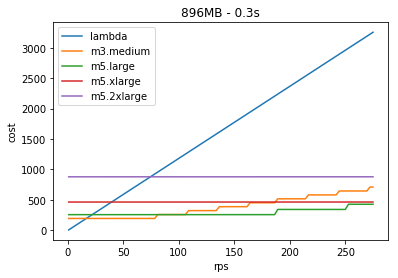

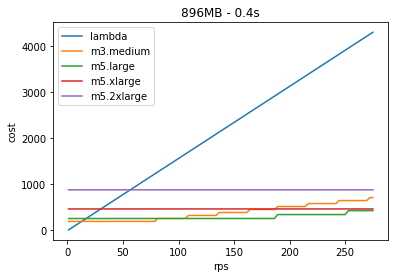

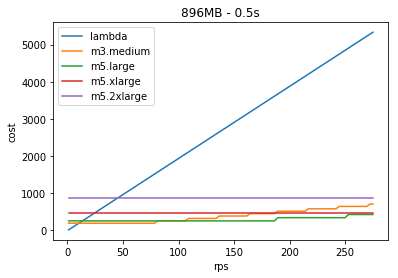

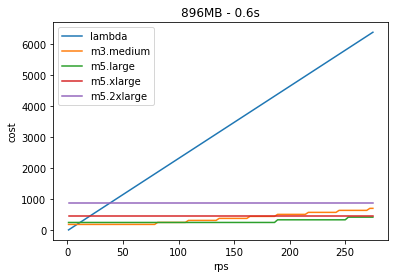

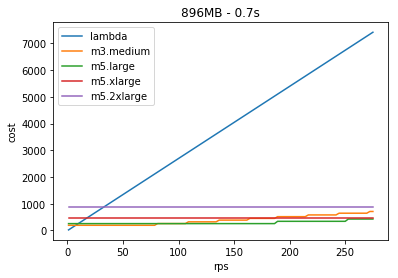

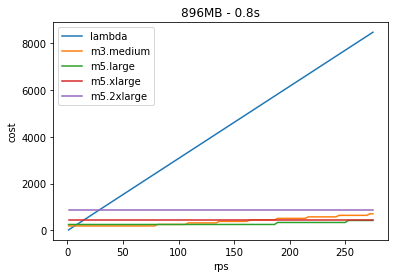

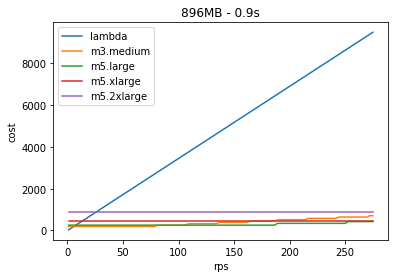

In [5]:

for memory in range(128, 1024, 128):
    for process_time in np.arange(0.3, 1.0, 0.1):
        plot(memory=memory, process_time=process_time, title='{}MB - {:.1f}s'.format(memory, process_time))


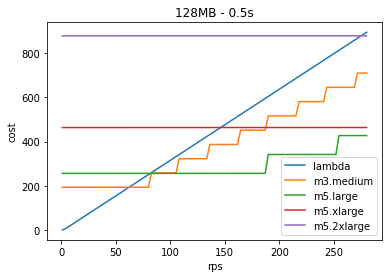

In [6]:

plot(memory=128, process_time=0.5, max_rps=280, title='{}MB - {:.1f}s'.format(128, 0.5))


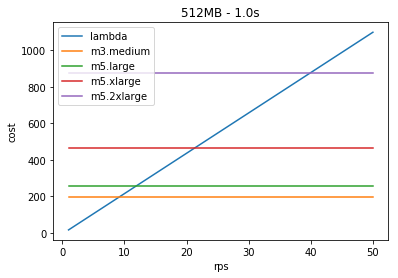

In [7]:

plot(memory=512, process_time=1.0, max_rps=50, title='{}MB - {:.1f}s'.format(512, 1))


In [8]:
# Cost Model for Lambda
rps = 35    # requests per second
mem = .125  # memory consumption in GB
time = 0.5  # execution time in seconds

_rpm = rps * 60 * 60 * 24 * 30                  # convert to requests per month
_compute_time = _rpm * time                     # calculate total compute time
_gb_per_month = _compute_time * mem - 400000    # compute GB/month and subtract off free
_compute_cost = _gb_per_month * 0.00001667      # total compute costs
_request_millions = _rpm - 1000000              # subtract off free
_request_millions = _request_millions / 1000000 # convert to millions of requests
_request_cost = _request_millions * 0.2         # total request cost
_total_cost = _compute_cost + _request_cost     # total cost

print 'RPS: {} -- Memory: {} -- Execution Time: {}'.format(rps, mem, time)
print 'Total monthly cost: ${:,.2f}'.format(_total_cost)

RPS: 35 -- Memory: 0.125 -- Execution Time: 0.5
Total monthly cost: $105.65


In [9]:
# Assume that requests per second is the highest LCU rule
lcu_total = rps / 25 * elb_lcu

m3m_monthly = m3m * 24 * 30 + elb * 24 * 30 + lcu_total
m5l_monthly = m5l * 24 * 30 + elb * 24 * 30 + lcu_total
m5xl_monthly = m5xl * 24 * 30 + elb * 24 * 30 + lcu_total
m52xl_monthly = m52xl * 24 * 30 + elb * 24 * 30 + lcu_total

m3m_instances = _total_cost / m3m_monthly
m5l_instances = _total_cost / m5l_monthly
m5xl_instances = _total_cost / m5xl_monthly
m52xl_instances = _total_cost / m52xl_monthly

print 'Lambda cost is equivalent to:'
print '{} m3.medium instances at ${:,.2f} per instance - total ${:,.2f}'.format(int(math.ceil(m3m_instances)), m3m_monthly, math.ceil(m3m_instances) * m3m_monthly)
print '{} m5.large instances at ${:,.2f} per instance - total ${:,.2f}'.format(int(math.ceil(m5l_instances)), m5l_monthly, math.ceil(m5l_instances) * m5l_monthly)
print '{} m5.xlarge instances at ${:,.2f} per instance - total ${:,.2f}'.format(int(math.ceil(m5xl_instances)), m5xl_monthly, math.ceil(m5xl_instances) * m5xl_monthly)
print '{} m5.2xlarge instances at ${:,.2f} per instance - total ${:,.2f}'.format(int(math.ceil(m52xl_instances)), m52xl_monthly, math.ceil(m52xl_instances) * m52xl_monthly)

print

# For high availabilty
min_instances = 3

m3m_required = max(int(math.ceil(float(rps) / m3m_rps)), min_instances)
m5l_required = max(int(math.ceil(float(rps) / m5l_rps)), min_instances)
m5xl_required = max(int(math.ceil(float(rps) / m5xl_rps)), min_instances)
m52xl_required = max(int(math.ceil(float(rps) / m52xl_rps)), min_instances)

print '{} m3.medium instances required - ${:,.2f}'.format(m3m_required, m3m_required * m3m_monthly)
print '{} m5.large instances required - ${:,.2f}'.format(m5l_required, m5l_required * m5l_monthly)
print '{} m5.xlarge instances required - ${:,.2f}'.format(m5xl_required, m5xl_required * m5xl_monthly)
print '{} m5.2xlarge instances required - ${:,.2f}'.format(m52xl_required, m52xl_required * m52xl_monthly)
print
print 'Total monthly lambda cost: ${:,.2f}'.format(_total_cost)


Lambda cost is equivalent to:
2 m3.medium instances at $64.45 per instance - total $128.90
2 m5.large instances at $85.33 per instance - total $170.66
1 m5.xlarge instances at $154.45 per instance - total $154.45
1 m5.2xlarge instances at $292.69 per instance - total $292.69

3 m3.medium instances required - $193.34
3 m5.large instances required - $255.98
3 m5.xlarge instances required - $463.34
3 m5.2xlarge instances required - $878.06

Total monthly lambda cost: $105.65
